# Smart feature selection with sklearn pipelines, feature-engine, and probatus

* Gilles Verbockhaven (gilles.verbockhaven@ing.com)
* Ryan Chaves (ryan.chaves@ing.com)

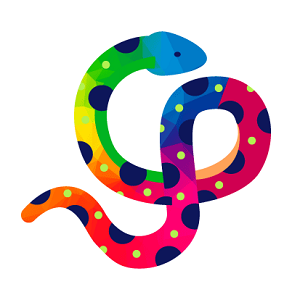

## Feature quality selection, including `feature-engine` & `DropHighPSIFeatures`

This notebook is based in part on an internal ING Code Breakfast workshop prepared by our RPAA Team colleagues João Pinto Moura (joao.pinto.moura@ing.com) and Tingting Qiao (tingting.qiao@ing.com). Kudos!

Goal of this notebook: Show how to use the functionalities of `feature-engine` to remove features based on various quality criteria:
- Correlation
- Uniqueness
- Feature stability
- Relationship with the target

**Feature selection is an important part of the modelling pipeline**

- Feature engineering (generation) is important because it is the basis of modelling; it provides the required information to your model.
- Features are often generated in an automated way. This results in:
  - Many features, sometimes hundreds or even thousands
  - Features containing little to no information related to the target
  - Correlated or even duplicate features
  - "Meaningless" features (statistically or from a business point of view) 

**Never blindly use all features**

When using decision-tree-based algorithms, a large amount of features can be used. However:

- You want to work with only the most relevant features and disregard the ones that have little impact.
  - It can be hard to find stable estimates of the importance of [multi collinear features](https://en.wikipedia.org/wiki/Multicollinearity).
  - Each feature must be monitored in production, which can be time consuming.
- You want to remove features with poor quality, e.g.:
  - Low variance
  - Drifted features (e.g. drift in time)

**Use a quality selection pipeline**

There are functionalities for feature selection based on quality criteria which can help you reduce the number of features to a smaller set of more interesting ones.

- We will use well-known packages, like `scikit-learn` and `feature-engine` to provide some basic examples.
- We focus on binary supervised classification settings, even though most techniques can also be applied for other algorithms / model types.
- We ignore dimensionality reduction methods (e.g. PCA), since they usually make features hard to understand and therefore decrease model interpretation.

### Setup

#### Import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import math

from datetime import date
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

#### Generate a toy data set

We start by generating a data set that has a lot of the most commonly encountered issues:

- 8 informative features (`n_informative=8`)
- 2 features are duplicates of others (`n_repeated=2`)
- 2 features have a high correlation with others (`n_redundant=2`)
- 2 features have no relation with the target (`n_features - (n_informative + n_redundant + n_repeated)`)
- 1 constant feature (`fconst`)

We will introduce you to a few selectors that are able to automatically find and drop the less interesting features.

In [2]:
def make_df(n_samples, n_features, n_informative, n_redundant, n_repeated):
    # Define number of features in the dataset
    feature_names = [f'f{idx}' for idx in range(1, n_features + 1)]

    # Prepare sample data set
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, 
                               n_redundant=n_redundant, n_repeated=n_repeated, n_clusters_per_class=1, random_state=42)

    X = pd.DataFrame(X, columns=feature_names)
    # Add a constant feature
    X = X.assign(fconst='21')

    # Create a date (e.g. data collection time)
    X['time'] = [date(year, 1, 1) for year in range(1000, 1000 + n_samples)]
    # and a drifted feature
    def drift(i, shift=500, scaler=100, multiplier=5):
        scaled = (i - shift) / scaler
        lr = math.exp(scaled) / (1 + math.exp(scaled))
        return lr * multiplier

    X['fdrifted'] = [drift(i) for i in range(n_samples)] + X['f1']
    
    # Let's shuffle the dataframe and reset the index to remove the correlation
    # between the index and the time variables.
    X = X.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the data set into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = make_df(n_samples=1000, n_features=14, n_informative=8, n_redundant=2, n_repeated=2)

In [4]:
X_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,fconst,time,fdrifted
541,0.315208,0.165973,-0.455265,1.230478,-2.355761,0.532805,0.165973,-1.459281,-0.424927,-0.481113,0.532805,1.181398,-0.466431,0.522459,21,1271-01-01,0.774981
440,3.182522,2.468385,-3.860928,1.912530,0.325369,0.646273,2.468385,0.722990,-0.103920,2.269616,0.646273,-2.103202,0.627392,-1.660623,21,1223-01-01,3.477358
482,0.989527,2.398190,-0.542532,1.868272,1.984632,1.989290,2.398190,-1.285305,-0.633444,2.369770,1.989290,-0.191011,-0.485791,-1.693060,21,1011-01-01,1.026853
422,-0.624577,1.550901,-2.709133,-1.572099,-0.799271,-0.586931,1.550901,-1.209859,-0.512580,-0.391629,-0.586931,-1.544796,-0.359699,-0.317450,21,1483-01-01,1.663433
778,-2.353799,-0.968235,3.755823,-1.040770,-1.870091,-3.372080,-0.968235,-0.929689,0.096736,1.034186,-3.372080,2.373450,0.074004,3.116186,21,1258-01-01,-1.945498


#### Install `feature-engine`

`scikit-learn` has [some feature selectors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection), but the choice is relatively limited.

One great Python package is [feature-engine](https://feature-engine.readthedocs.io/en/1.1.x/selection/index.html).
This includes a large and useful variety of feature selectors that we frequently use in ING RPAA projects.
It is compatible with the `scikit-learn` `Pipeline`s (see first notebook of this workshop), so it is very easy to integrate into most projects.

In [5]:
#! pip install feature_engine
#! pip install probatus

### Constant or low variance features

Constant features, or features with very low variance, generally have little information that ML algorithms can learn from.
Because of this, we can (and should, to reduce model complexity) safely drop them from the modelling data set.

Here we use `feature_engine.selection.DropConstantFeatures` to find and drop the `fconst` constant feature that we added to the data set. 
This class drops all features that have the same value in more than a fraction (`tol`) of rows (samples) of the total number of rows.

This class is roughly equivalent to `sklearn.feature_selection.VarianceThreshold`.

In [6]:
from feature_engine.selection import DropConstantFeatures

In [9]:
# Set up the transformer
transformer_drop_constant = DropConstantFeatures(tol=0.99, missing_values='ignore')

# Fit the transformer
transformer_drop_constant.fit(X_train)
print(f"Features to drop: {transformer_drop_constant.features_to_drop_}")

# Transform the data
X_train_no_constant = transformer_drop_constant.transform(X_train)
print(f"Features remaining:\n{X_train_no_constant.columns.to_list()}")

Features to drop: ['fconst']
Features remaining:
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'time', 'fdrifted']


### Correlated features

*Highly* correlated features contain essentially the same information. It is usually beneficial to pick one of the correlated features and remove the other one. Selecting which of the correlated pair to drop and which to keep can be done:
- Arbitrarily (sounds like a bad idea, but if you are using a high threshold, it probably doesn't matter much, because they are nearly identical)
- Based on feature statistics (e.g. number of missing values, variance, correlation with target)
- Based on predictive power

We use `feature_engine.selection.DropCorrelatedFeatures` to drop the correlated features that are in the data set (i.e. the ones created when we passed the `n_redundant=2` arg to `make_classification`). 

This class finds features with a correlation coefficient higher than `threshold` and keeps only one of those features.
It accepts numerical features only. Also, by default, the coefficient used is Pearson's cross-correlation coefficient, but you can pass the arg `method` to use Spearman's or Kendall's instead if they are more suitable to your data set. See the [`DropCorrelatedFeatures` docs](https://feature-engine.readthedocs.io/en/latest/api_doc/selection/DropCorrelatedFeatures.html) for more options.

In [10]:
from feature_engine.selection import DropCorrelatedFeatures

In [11]:
# Set up the transformer
transformer_drop_correlated = DropCorrelatedFeatures(threshold=0.8)

# Fit the transformer
transformer_drop_correlated.fit(X_train_no_constant)
print(f"Features to drop: {transformer_drop_correlated.features_to_drop_}")

# Transform the data
X_train_no_correlated = transformer_drop_correlated.transform(X_train_no_constant)
print(f"Features remaining:\n{X_train_no_correlated.columns.to_list()}")

Features to drop: {'f11', 'f7', 'f12'}
Features remaining:
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f13', 'f14', 'time', 'fdrifted']


**Tip:** When multiple features are correlated with each other, which ones should you drop?
[`SmartCorrelatedSelection`](https://feature-engine.readthedocs.io/en/1.1.x/selection/SmartCorrelatedSelection.html) automatically finds clusters of correlated features and lets you keep only the:
- Feature with fewest missing values
- Feature with most unique values
- Feature with highest variance
- Best performing feature according to an estimator defined by you

### Features with a drift

Once deployed in production, the performance of ML models usually erode with time because the world is changing. 
- Macro-economic changes (e.g. inflation, recessions, crisis)
- Customer behavior changes (e.g. home-banking penetration)
- Process/policy changes (e.g. new products)

Changes in the data distribution in production could lead to biased predictions. Data drift is the primary reason why model accuracy decreases over time.

![shift](../pictures/Shift.png)
</p>
<p align = "left">
<span style="color:skyblue">Figure 1 - Example of drift in data distribution</span>
</p>

#### PSI: A simple way to assess population shift

PSI stands for Population Stability Index. It is a single number that summarizes how much two distribution differ, and is widely used in the banking industry. It is computed in the following way:
- Define the two distributions to compare (e.g. train vs. test or in-time vs. out-of-time).
- Define buckets (bins) to discretize the reference population (usually train).
- Compute the percentage of observations falling in each bucket for train.
- Compute the percentage of observations falling in each bucket for test.
- Compute the `PSI` using the following formula:

![PSI](../pictures/PSI.png)

</p>
<p align = "left">
<span style="color:skyblue">Equation 1 - Formula to compute the PSI value. A threshold of 0.25 is standard to design a significant change in population.</span>
</p>

**More info:** [PSI is related to the Kullback Liebler divergence](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations)

#### What are the use cases?

- Data is collected over a long period of time.
- Data is collected over different groups (e.g. if you are developing a common model for multiple product types, i.e. mortgages, personal loans, credit cards)

![internet banking Belgium](../pictures/IB_share.png)
</p>
<p align = "left">
<span style="color:skyblue">Figure 2 - Penetration of Internet banking in Belgium (https://www.statista.com) </span>
</p>

**Careful**:

- High PSI values may come from "natural" behavior like seasonality or Covid spike.
- PSI values depend on the bucketing strategy and number of buckets.
- PSI is a univariate measure.

#### How to deal with high PSI features?

- A feature with a high PSI value is not bad by definition.
- It is important to understand the nature of the high PSI.
- Some features may have lower PSI values once transformed or normalized, e.g. Income => Income / Average(Income)

### Feature drift: PSI tooling

- The [`probatus`](https://ing-bank.github.io/probatus/tutorials/nb_distribution_statistics.html) package contains several functionalities to estimate population shift.
- `feature-engine` has a transformer to remove features with high PSI (developed by ING RPAA)

#### `DropHighPSIFeatures` from `feature-engine`

[`DropHighPSIFeatures`](https://feature-engine.readthedocs.io/en/1.2.x/api_doc/selection/DropHighPSIFeatures.html) signature is mostly driven by:
- How to split the dataframe in order to define the distributions to compare.
- How to compute the PSI (buckets and threshold)

Further reading:
- https://trainindata.medium.com/how-to-select-features-based-on-the-population-stability-index-58a1f0283583
- https://github.com/feature-engine/feature-engine-examples/blob/main/selection/Drop-High-PSI-Features.ipynb
- https://github.com/feature-engine/feature_engine/blob/main/docs/user_guide/selection/DropHighPSIFeatures.rst

Remember, we introduced a `drifted` feature in the dataset. Let's first look at the behavior of the feature over time.

In [12]:
import matplotlib

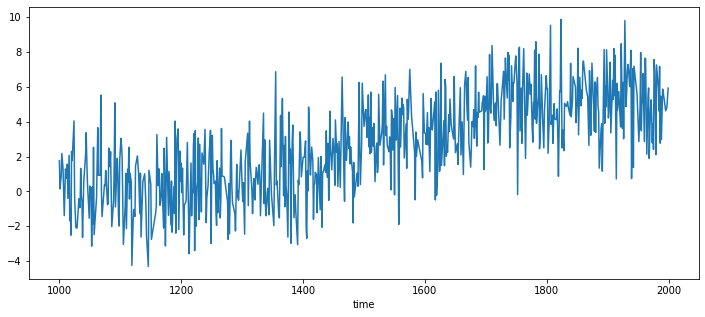

In [14]:
X_train.groupby('time')['fdrifted'].mean().plot(figsize=(12, 5));

Looking at the cumulative density function (CDF) before and after 1500 clearly shows a difference in distribution.

In [17]:
#!pip install seaborn

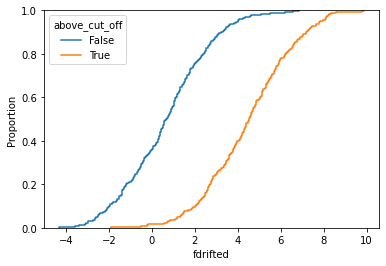

In [20]:
import seaborn as sns

X_train['above_cut_off'] = X_train.time > date(1500, 1, 1)

sns.ecdfplot(data=X_train, x='fdrifted', hue='above_cut_off');

In [21]:
from feature_engine.selection import DropHighPSIFeatures

In [22]:
# Set up the transformer
transformer_psi = DropHighPSIFeatures(split_col='time', cut_off=date(1789, 7, 14))

# Fit the transformer
transformer_psi.fit(X_train_no_correlated, y=y_train)
print(f"Features to drop: {transformer_psi.features_to_drop_}")

# Transform the data
X_train_no_corr_target = transformer_psi.transform(X_train_no_correlated)
print(f"Features remaining:\n{X_train_no_corr_target.columns.to_list()}")

Features to drop: ['fdrifted']
Features remaining:
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f13', 'f14', 'time']


In [29]:
transformer_psi.psi_values_

{'f1': 0.040028163520957526,
 'f2': 0.04903601046867709,
 'f3': 0.1773192969111151,
 'f4': 0.07821614775674682,
 'f5': 0.0674080166889609,
 'f6': 0.08253123784159076,
 'f8': 0.04104467713747409,
 'f9': 0.10625761905421968,
 'f10': 0.08407756283310111,
 'f13': 0.05284592071083042,
 'f14': 0.1035049717122653,
 'fdrifted': 2.9760117997649234}

## Bringing it all together: Feature selectors and the `Pipeline` syntax

`feature-engine` is compatible with the `scikit-learn` `Pipeline` API. This means they can easily be combined.

Let's illustrate how this works:

In [30]:
# Re-creating the data set
X_train, X_test, y_train, y_test = make_df(n_samples=1000, n_features=14, n_informative=8, n_redundant=2, n_repeated=2)

In [31]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures

# Set up a pipeline
fs_pipeline = Pipeline(
    [
        ("drop_constant", DropConstantFeatures(tol=0.99, missing_values='ignore')), 
        ("drop_correlated", DropCorrelatedFeatures(threshold=0.85)), 
        ("drop_psi", DropHighPSIFeatures(split_col='time', cut_off=date(1789, 7, 14))),
        ("drop_time", DropFeatures(['time'])),
    ]
)

# Fit the pipeline
fs_pipeline.fit(X_train, y_train)

# Transform the data
X_train_transformed = fs_pipeline.transform(X_train)
print(f"Features remaining:\n{X_train_transformed.columns.to_list()}")

Features remaining:
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f13', 'f14']


**Caerful:** The order of the selectors/transformers in the `Pipeline` does matter. Try to put the univariate selectors first.

> Tip: in most `feature-engine` selectors, you can define to which variables the selector should be applied to, using the argument `variables`. You can use this to ignore information columns which should not be used as features, or to apply different pipelines to categorical and numerical columns, for example.

## Something to try at home

- After looking at the data, you realize that some of the features (`f2`, `f3` and `f14`) are not suitable for modelling. 
- Add the `DropFeature` transformer to the pipeline and re-run it. 
- Check the functionality removed the correct features.
- Try also `SmartCorrelatedSelection`.

End of this notebook and the workshop. 

*We hope this helps you streamline your model development workflows and create more robust models! Cheers, Gilles & Ryan*